In [2]:
import os
import re
import pandas as pd
import numpy as np
import tiktoken
import openai
from openai import OpenAI
client = OpenAI()

In [2]:
openai.api_key = os.environ["OPENAI_API_KEY"]

### Loading file / Preprocessing

In [5]:
# 파일 불러오기
data = pd.read_csv("../crawling/position_data.csv")

# 전처리 (이모티콘 같은 특수 기호 제거, 데이터 합치기)
pattern = r'[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣!@#$%^&*(),.?":{}|<>/\s]+|(https?://\S+)'

col_to_fix = ('serviceInfo', 'responsibility', 'qualifications', 
              'preferredRequirements', 'welfares', 'recruitProcess')
columns = ['id', 'companyName', 'serviceInfo', 'responsibility', 
           'qualifications', 'preferredRequirements', 'welfares', 
           'recruitProcess', 'location', 'companyProfileId', 'techStacks', 
           'employmentType', 'experienceRequirements', 'address', 
           'isDomestic', 'jobCategories_id', 'jobCategories', 'career']

def clean_text(text):
    return re.sub(r'\n', ' ', re.sub(r'\n\n+', ' ## ', re.sub(pattern, '', str(text))))

def combine_func(row):
    return "## ".join([str(row[col]) for col in columns])

def expression_col(row):
    return ", ".join((", ".join(eval(row['techStacks'])),  row['jobCategories'], row['responsibility']))

for col in col_to_fix:
    data[col] = data[col].apply(clean_text)
data["content"] = data.apply(combine_func, axis=1)
data["expression"] = data.apply(expression_col, axis=1)

# title, content 두 열로 데이터 정리
df = pd.DataFrame(data, columns=['title', 'content', 'expression'])

In [6]:
# title, content 두 열로 정리된 데이터 저장
df.to_csv("contents_df.csv", index=False, encoding='utf-8')

### Tokenization

<Axes: >

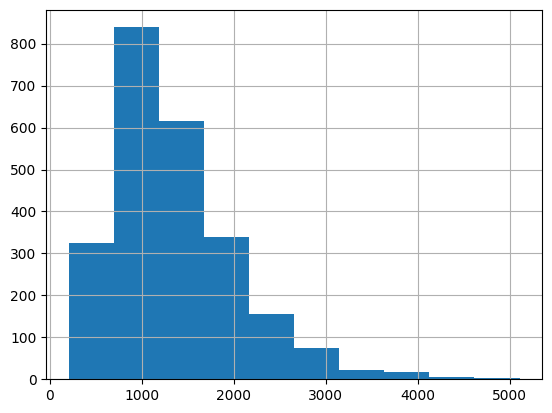

In [5]:
# 토큰화
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df['content'].apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [6]:
# max_tokens = 3000
# def split_into_many(text, max_tokens = max_tokens):

#     # 일단 문장으로 쪼개기
#     sentences = text.split('. ')

#     # 문장마다 몇 토큰 들어가는지 세어 주기.
#     n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
#     chunks = []
#     tokens_so_far = 0
#     chunk = []


#     for sentence, token in zip(sentences, n_tokens):

#         # 문장의 토큰 수와 현재까지의 토큰 수의 합이 최대 토큰 수를 초과하면, 해당 청크를 청크 목록에 추가하고 청크 및 현재까지의 토큰 수를 초기화한다.
#         if tokens_so_far + token > max_tokens:
#             chunks.append(". ".join(chunk) + ".")
#             chunk = []
#             tokens_so_far = 0

#         if token > max_tokens:
#             continue

#         chunk.append(sentence)
#         tokens_so_far += token + 1

#     if chunk:
#         chunks.append(". ".join(chunk) + ".")

#     return chunks

In [7]:
# shortened = []
# # 데이터 프레임 순회하기
# for row in df.iterrows():

#     # If the content is None, go to the next row
#     if row[1]['content'] is None:
#         continue

#     # If the number of tokens is greater than the max number of tokens, split the content into chunks
#     if row[1]['n_tokens'] > max_tokens:
#         shortened += split_into_many(row[1]['content'])
    
#     # Otherwise, add the content to the list of shortened texts
#     else:
#         shortened.append( row[1]['content'] )

In [8]:
max_tokens = 3000
def split_large_text(large_text, max_tokens=max_tokens):
    enc = tiktoken.get_encoding("cl100k_base")
    tokenized_text = enc.encode(large_text)

    chunks = []
    current_chunk = []
    current_length = 0

    for token in tokenized_text:
        current_chunk.append(token)
        current_length += 1

        if current_length >= max_tokens:
            chunks.append(enc.decode(current_chunk).rstrip(' .,;'))
            current_chunk = []
            current_length = 0

    if current_chunk:
        chunks.append(enc.decode(current_chunk).rstrip(' .,;'))

    return chunks

df['splitted_content'] = df['content'].apply(split_large_text)
df = df.explode("splitted_content")
df['spllitted_n_tokens'] = df['splitted_content'].apply(lambda x: len(tokenizer.encode(x)))
df = df.reset_index(drop=True)

In [9]:
df = df[['title','splitted_content', 'spllitted_n_tokens']].rename(columns={'splitted_content':'content', 'spllitted_n_tokens':'n_tokens'})

In [10]:
def combine_info(row):
    title = row['title']
    content = row['content']

    combined = [f"title: {title}", f"content: \n{content}"]
    combined = "\n\n###\n\n".join(combined)
    
    return combined

df["combined"] = df.apply(combine_info, axis=1)

In [11]:
df.head()

,title,content,n_tokens,combined
0,개발 팀장,"21310## 한국해양기상기술## 한국 해양 기상 기술은 해양,기상환경의 분석, 예...",940,title: 개발 팀장\n\n###\n\ncontent: \n21310## 한국해양...
1,[Moloco] Senior Data Scientist,21110## 몰로코## 몰로코는 모바일 광고 기반의 머신러닝 솔루션 기업으로서 지...,1613,title: [Moloco] Senior Data Scientist\n\n###\n...
2,AI 엔지니어,"20853## 피매치## ""고객이 자기주도적으로 웰니스를 실현하는 세상을 꿈꾸는 피...",1272,title: AI 엔지니어\n\n###\n\ncontent: \n20853## 피매...
3,JAVA 백엔드 개발자(차장급),21851## 아파트아이## 아파트아이란? 아파트아이는 아파트 단지를 기반으로 고...,1480,title: JAVA 백엔드 개발자(차장급)\n\n###\n\ncontent: \n...
4,[5년 이상 리더급] 풀스택 소프트웨어 엔지니어,22041## 다이얼로그디자인에이전시## dda Inc.는 2016년 창업한 임직원...,2168,title: [5년 이상 리더급] 풀스택 소프트웨어 엔지니어\n\n###\n\nco...


In [12]:
df.describe()

,n_tokens
count,2462.000000
mean,1313.222583
std,645.405047
min,1.000000
25%,823.000000
50%,1197.000000
75%,1679.750000
max,3000.000000


### TF-IDF

In [39]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# def cal_tfidf(documents):
#     # Document Term Matrix
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform(documents)

#     # Term Freqeuncy
#     tf = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

#     # Document Frequency 
#     _df = tf.astype(bool).sum(axis = 0)

#     # Inverse Document Frequency
#     idf = np.log((len(tf)) / (_df+1))

#     # TF-IDF
#     tfidf = tf * idf                      
#     tfidf = tfidf / np.linalg.norm(tfidf, axis = 1, keepdims = True)
#     return tfidf

# def get_tfidf_vec(documents):
#     documents = [document.replace("\n", " ") for document in documents]
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform(documents)

#     return pd.DataFrame([list(tfidf_matrix.toarray())]).transpose()

In [ ]:
# df["tfidf_embedding"] = get_tfidf_vec(df.combined)
# df["tfidf_embedding"]

### Embedding

In [43]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [44]:
df["embedding"] = df.combined.apply(get_embedding)
df.to_pickle("./job-processed.pkl")

In [48]:
df = pd.read_pickle("./job-processed.pkl")

In [61]:
def get_embedding2(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

df["embedding2"] = df.combined.apply(get_embedding2)
df.to_pickle("./job-processed2.pkl")

In [49]:
df

,title,content,n_tokens,combined,embedding
0,개발 팀장,"21310## 한국해양기상기술## 한국 해양 기상 기술은 해양,기상환경의 분석, 예...",940,title: 개발 팀장\n\n###\n\ncontent: \n21310## 한국해양...,"[-0.03155944496393204, 0.04615981504321098, 0...."
1,[Moloco] Senior Data Scientist,21110## 몰로코## 몰로코는 모바일 광고 기반의 머신러닝 솔루션 기업으로서 지...,1613,title: [Moloco] Senior Data Scientist\n\n###\n...,"[0.03438451886177063, 0.0353199802339077, -0.0..."
2,AI 엔지니어,"20853## 피매치## ""고객이 자기주도적으로 웰니스를 실현하는 세상을 꿈꾸는 피...",1272,title: AI 엔지니어\n\n###\n\ncontent: \n20853## 피매...,"[-0.02837320603430271, 0.00960796233266592, 0...."
3,JAVA 백엔드 개발자(차장급),21851## 아파트아이## 아파트아이란? 아파트아이는 아파트 단지를 기반으로 고...,1480,title: JAVA 백엔드 개발자(차장급)\n\n###\n\ncontent: \n...,"[-0.02582773193717003, 0.02387033961713314, 0...."
4,[5년 이상 리더급] 풀스택 소프트웨어 엔지니어,22041## 다이얼로그디자인에이전시## dda Inc.는 2016년 창업한 임직원...,2168,title: [5년 이상 리더급] 풀스택 소프트웨어 엔지니어\n\n###\n\nco...,"[-0.04625161364674568, 0.011008037254214287, 0..."
...,...,...,...,...,...
2457,펌웨어 설계 연구원,12676## 은성글로벌## (주)은성글로벌은 1997년에 설립된 회사로 매출액 4...,334,title: 펌웨어 설계 연구원\n\n###\n\ncontent: \n12676##...,"[-0.010489491745829582, 0.02371380850672722, 0..."
2458,LASER 자동화 설비 제어 S/W 개발자,"21127## 레이저발테크놀러지## 당사는 본사가 홍콩에 있고 한국, 중국, 싱가폴...",594,title: LASER 자동화 설비 제어 S/W 개발자\n\n###\n\nconte...,"[-0.032893624156713486, 0.05549400672316551, 0..."
2459,"영상처리, 비전 (Vision) S/W 채용",22264## 포우## 머신비젼 렌즈시스템 전문 3D TOF센서용 계측시스템 센서 ...,398,"title: 영상처리, 비전 (Vision) S/W 채용\n\n###\n\ncont...","[-0.015528375282883644, 0.0512276291847229, -0..."
2460,Dell Tech 총판 프리세일즈/컨설팅 (3년 이상),21515## 다올티에스## 다올티에스는 Dell Technologies 비즈니스로...,662,title: Dell Tech 총판 프리세일즈/컨설팅 (3년 이상)\n\n###\n...,"[-0.02550021931529045, -0.007216448895633221, ..."
